In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import  PartialDependenceDisplay,permutation_importance
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import seaborn as sns


# Load the dataset
data = pd.read_csv('day.csv')

# Select relevant features and target
features = ['hum','temp', 'windspeed']
target = 'cnt'
X = data.loc[:,'season':'windspeed']
y = data['cnt']  # Target is count of bike rentals

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled= pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [4]:
#Fit a model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled[features], y_train)

# Print the coefficients
print(f'Intercept {lin_reg.intercept_:.1f}')
for coef, feature in zip(lin_reg.coef_, features):
    print(f'{feature}_s:{coef:.2f}')

Intercept 4561.0
hum_s:-425.53
temp_s:1195.36
windspeed_s:-321.21


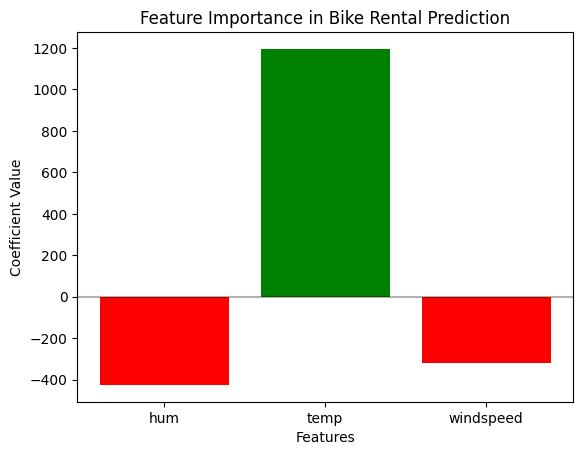

In [5]:
features = lin_reg.feature_names_in_
coefficients = lin_reg.coef_

# Create bar plot
colors = ['green' if c > 0 else 'red' for c in coefficients]
bars = plt.bar(features, coefficients, color=colors)

# Add labels and title
plt.title('Feature Importance in Bike Rental Prediction')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Show the plot
plt.show()

Coefficient Comparison:
           Original Model  Expanded Model  Absolute Difference
hum              -425.534        -479.680               54.147
temp             1195.356        1050.774              144.582
windspeed        -321.208        -257.286               63.922
season                NaN         467.065                  NaN
weekday               NaN         118.926                  NaN


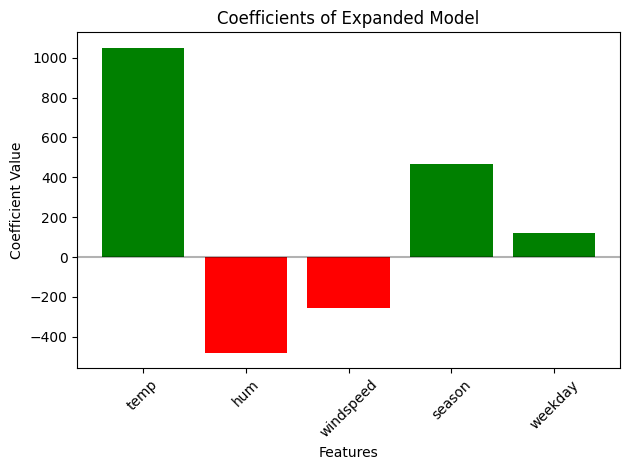

In [6]:
# Prepare expanded feature set
expanded_features = ['temp', 'hum', 'windspeed', 'season', 'weekday']

expanded_model = LinearRegression()
expanded_model.fit(X_train_scaled[expanded_features], y_train)
    
# Create comparison DataFrame
original_coef = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_, name='Original Model')
expanded_coef = pd.Series(expanded_model.coef_, index=expanded_model.feature_names_in_, name='Expanded Model')

# Combine into a DataFrame
comparison_df = pd.concat([original_coef, expanded_coef],axis=1)

# Add absolute difference for common features
comparison_df['Absolute Difference'] = abs(
    comparison_df['Original Model'] - comparison_df['Expanded Model']
).round(3)

# Round all numeric values
comparison_df = comparison_df.round(3)

print("Coefficient Comparison:")
print(comparison_df)

#Create a bar plot of the expanded model coefficients
colors = ['green' if c > 0 else 'red' for c in expanded_model.coef_]
plt.bar(expanded_features, expanded_model.coef_, color=colors)
plt.title('Coefficients of Expanded Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Select a specific example
example_idx = 0
example = X_test_scaled.loc[example_idx, features]

# Calculate baseline and contributions
baseline = lin_reg.intercept_
contributions = example * lin_reg.coef_
final_prediction = lin_reg.predict(example.values.reshape(1,-1))

# Print analysis
print(f"Baseline prediction: {baseline:.2f}")
print("\nFeature contributions:")
for feature, value, contrib in zip(features, example, contributions):
    direction = "increases" if contrib > 0 else "decreases"
    print(f"{feature:} {value:>6.2f}: {direction} prediction by {abs(contrib):.2f}")
print("-" * 50)
print(f"Final prediction: {final_prediction[0]:.2f}")
print(f"Sum contributions: {contributions.sum():.2f}")
print(f"Sum contributions + baseline: {contributions.sum()+baseline:.2f}")

Baseline prediction: 4560.98

Feature contributions:
hum   0.72: decreases prediction by 307.27
temp  -0.13: decreases prediction by 160.38
windspeed  -0.21: increases prediction by 68.74
--------------------------------------------------
Final prediction: 4162.07
Sum contributions: -398.91
Sum contributions + baseline: 4162.07


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
